# Análise de Sentimento usando uma rede recorrente


<table>
<tr>
<td>
<img align="middle"  width='400' heith='100'   src='images/rnn_sent.png'>
</td>
</tr>
</table>


Nesse notebook vamos usar um dataset sintético para apreender como realizar análise de sentimento usando uma rede recorrente.

Se você nunca usou a biblioteca [PyTorch](https://pytorch.org/) antes, vale a pena rever os conceitos principais nesses notebooks:

- [PyTorch basico 1](https://github.com/MLIME/MAC0460/blob/master/notebooks/pytorch_basico1.ipynb)

- [PyTorch basico 2](https://github.com/MLIME/MAC0460/blob/master/notebooks/pytorch_basico2.ipynb)



In [1]:
# notebook feito para a versão 0.4.1 

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import re
from torchtext import data
import torch.optim as optim
from plots.plots import plot_confusion_matrix, plot_histogram_from_labels
from text_generation.sentiment import generate_sentiment_data

# % matplotlib inline

Vamos usar um dataset bem simples. São sentenças curtas que atribuem um atributo que pode ser negativo ou positivo a uma pessoa:

- **Paula sempre foi curiosa** (positivo)

- **Alberto é prepotente** (negativo)

Para não ser muito simplista também vamos colocar algumas sentenças que são neutras, as vezes elas não são
nem positivas nem negativas, as vezes elas são simplesmente ambíguas:

- **Clara nunca foi esmerada** (neutro)

- **Amanda é tanto carinhosa quanto frívolae** (neutro)

Esse dataset é *sintético*, i.e., ele é gerado automaticamente por meio de um  script. Isso é mais fácil de gerar, mas são dados bem artificiais. Dados reais são mais complexos e possuem maior ruido. 

In [2]:
generate_sentiment_data()

Esses dados estão dividos entre **treino** e **teste**.

In [3]:
train_data_path = 'data/sentiment_train.csv'
test_data_path = 'data/sentiment_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data.head()

,text,label
0,Martino não é consciencioso nem estourado,2
1,Nina é tanto esperançosa quanto atrevida,2
2,Césaro é maravilhoso,1
3,Emaús não é honesto nem sarcástico,2
4,Lis é tanto bondosa quanto impulsiva,2


In [5]:
test_data.head()

,text,label
0,Adelmiro é sarcástico,0
1,Nicole nunca foi inflexível,2
2,Marcílio era tendencioso,0
3,Lindorfo era irresponsável,0
4,"Giovani parece ser impostor, mas eu não sei",2


Vamos colocar as legendas nas etiquetas

In [6]:
labels_legend = ['Negative','Positive', 'Neutral']
sentiment2int = {'Negative':0, 'Positive':1, 'Neutral':2}
int2sentiment = {i[1]: i[0] for i in sentiment2int.items()}
train_labels = train_data["label"].values
test_labels =  test_data["label"].values

Para vermos a distribuição das classes, vamos plotar um histograma. Note que aqui as classes estão balanceadas. Num dataset real de análise de sentimento isso geralmente não acontece. Isso fica claro quando analisamos textos políticos, como [*tweets*](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment), a grande maioria dos exemplos são de tweets com sentimento negativo. 

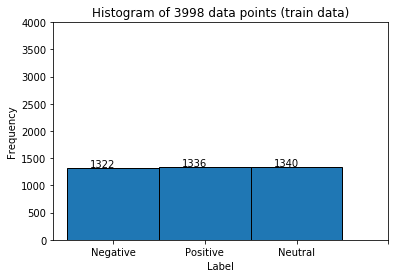

In [7]:
plot_histogram_from_labels(train_labels,
                           labels_legend,
                           "train data")

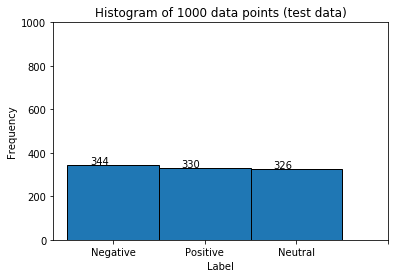

In [8]:
plot_histogram_from_labels(test_labels,
                           labels_legend,
                           "test data")

## Pré-processamento dos dados

Antes de transformar as palavras em índices, vamos **limpar o texto**, i.e. vamos deixar todo o texto em caixa baixa e vamos retirar as pontuações  

In [9]:
def simple_pre_process_text_df(data, field="text"):
    """
    process DataFrame in place
    
    :param data: DatFrame with text
    :type data: pd.DataFrame
    :param field: text field
    :type field: str
    """
    data[field] = data[field].apply(lambda x: x.lower())
    data[field] = data[field].apply(lambda x: re.sub(r'[^\w\s]','',x))

def simple_pre_process_text(sentence):
    """
    process sentence
    
    :param sentence: input sentence
    :type sentence: str
    :return: processed sentence
    :rtype: str
    """
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]','',sentence)
    return sentence

In [10]:
ints = np.random.randint(0, 100, 10)

print("====Antes do processamento====\n")

for i in ints:
    print(train_data["text"].values[i])

====Antes do processamento====

Jamim parece ser calculista, mas eu não sei
Egídio é encantador
Nicole é cívica, mas as vezes ele parece ser pedante
Catarina sempre foi colérica
Plínio era amável
Andrés não é ternurento nem narcisista
Catarina é empenhada, mas as vezes ele parece ser estourada
Narsélio parece ser impaciente, mas eu não sei
Nicole é cívica, mas as vezes ele parece ser pedante
Francisco é xenófobo


In [11]:
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)

In [12]:
print("====Depois do processamento====\n")

for i in ints:
    print(train_data["text"].values[i])

====Depois do processamento====

jamim parece ser calculista mas eu não sei
egídio é encantador
nicole é cívica mas as vezes ele parece ser pedante
catarina sempre foi colérica
plínio era amável
andrés não é ternurento nem narcisista
catarina é empenhada mas as vezes ele parece ser estourada
narsélio parece ser impaciente mas eu não sei
nicole é cívica mas as vezes ele parece ser pedante
francisco é xenófobo


Agora vamos salvar o resultado desse procesamento em outro csv:

In [13]:
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]]
train_data.to_csv('data/sentiment_train_clean.csv', header=False, index=False)
test_data.to_csv('data/sentiment_test_clean.csv', header=False, index=False)

## Hiper parâmetros

Para organizar o código vamos criar uma classe para guardar todos os hiper parâmetros.

In [14]:
class RNNConfig(object):
    """
    Holds RNN model hyperparams.
    
    :param vocab_size: vocabulary size
    :type vocab_size: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param embedding_dim: embedding dimension
    :type embedding_dim: int
    :param rnn_dim: rnn dimension
    :type rnn_dim: int
    :param output_dim: output dimension
    :type output_dim: int
    :param epochs: number of epochs
    :type epochs: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=256,
                 output_dim=3,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Com essa classe podemos listar todos os hiper parâmetros que vamos usar no treinamento e na criação dos iteradores

In [15]:
config = RNNConfig()
print("====Hiper parâmetros====\n")
print(config)

====Hiper parâmetros====

vocab_size = 25000
batch_size = 32
embedding_dim = 100
rnn_dim = 256
output_dim = 3
epochs = 3
learning_rate = 0.01
momentum = 0.1



## Transformando texto em tensores

Para faciliar a manipulação dos dados vamos usar certas classes do pacote [torchtext](https://torchtext.readthedocs.io/en/latest/index.html). 

Em particular, vamos usar a classe `data.Field` para guadar todos os dados de texto:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

E vamos usar a classe `data.LabelField` para guardar as etiquetas:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.


In [16]:
TEXT = data.Field()
LABEL = data.LabelField()

Vamos agora criar um dataset usando a classe `data.TabularDataset` passando como referência o dataset processado que acabamos de gerar.

In [17]:
train = data.TabularDataset(path='data/sentiment_train_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path='data/sentiment_test_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Vamos construir o vocabulário agora, i.e., vamos associar cada palavra a um índice. Note que o texto pode ter um grande número de palavras únicas, vamos deixar que o tamanho máximo do vocabulário seja de 25000 palavras.

In [18]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [19]:
print('Tamanho do vocabulário:', len(TEXT.vocab))
print('número de classes:', len(LABEL.vocab))

Tamanho do vocabulário: 1598
número de classes: 3


Vamos ver quais são as 10 palavras mais frequentes que ocorrem nesse corpus

In [20]:
top10 = TEXT.vocab.freqs.most_common(10)

print("====palavra (frequência)====\n")

for tuple_ in top10:
    print("{} ({})".format(tuple_[0], tuple_[1]))


====palavra (frequência)====

é (2333)
foi (1001)
não (680)
parece (671)
ser (671)
mas (671)
as (669)
vezes (669)
sempre (667)
era (662)


Na classe `TEXT.vocab` dois métodos são importantes para fazer a tradução de palavras para índices:

- `.itos` passa de índices para palavras.
- `.stoi` passa de palavras para índices.

In [21]:
print("Usando TEXT.vocab.itos\n")
print("====palavra, índice====\n")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)

Usando TEXT.vocab.itos

====palavra, índice====

<unk> 0
<pad> 1
é 2
foi 3
não 4
mas 5
parece 6
ser 7
as 8
vezes 9


Note que há dois tokens novos: 

- **$<$unk$>$**: token que simboliza uma palavra que não está no vocabulário (unknown)
- **$<$pad$>$**: token que simboliza uma palavra sem nenhum sentido associado. Esse token é usado apenas para preencher certas lacunas (padding) 



In [22]:
print("Usando TEXT.vocab.stoi\n")
print("====palavra, índice====\n")

example = "Betina é tanto ponderada quanto indiferente"
example = simple_pre_process_text(example)

for word in example.split():
    print(word, TEXT.vocab.stoi[word])

Usando TEXT.vocab.stoi

====palavra, índice====

betina 22
é 2
tanto 21
ponderada 502
quanto 20
indiferente 145


Vamos dividir o dataset de treinamento: 80$\%$ dos dados vão ser usados para o treinamento enquanto que 20$\%$ dos dados vão ser usados para validação

In [23]:
train, valid = train.split(0.8)

In [24]:
print('número de dados de treinamento:', len(train))
print('número de dados de validação:', len(valid))
print('número de dados de teste:', len(test))

número de dados de treinamento: 3198
número de dados de validação: 800
número de dados de teste: 1000


Lembre que um corpus contem sentenças de tamanhos diferentes. Mas nos vamos passar para o modelo lotes (*batches*) de sentenças de tamanho iguais. Por isso usamos o token $<$pad$>$, para preencher certas lacunas. Por exemplo considere as sentenças:

- faustino parece ser inseguro mas eu não sei
- helena sempre foi solícita
- sidnei era preocupado

depois de transformá-las em vetores de índices temos:

- [661, 5, 6, 330, 4, 12, 7, 13]
- [46, 9, 3, 234]
- [760, 8, 232]

igualando os tamanhos com o *padding* temos:

- [661, 5, 6, 330, 4, 12, 7, 13]
- [46, 9, 3, 234, 1, 1, 1, 1]
- [760, 8, 232, 1, 1, 1, 1, 1]


Note que se houver muita diferença de tamanho entre os exemplos vamos ter exemplos no batch com um número bem grande de padding o que não é muito eficiente, assim vamos usar a classe `data.BucketIterator` que define um iterador colocando sentenças de mesmo tamanho juntas, minimizando assim o uso de padding.

Vamos criar a classe `DataHolder` para guardar os dados de treinamento, validação e teste

In [25]:
class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.
    
    :param config: hyper params configuration
    :type config: RNNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torchtext.data.dataset.Dataset
    :param test_dataset: dataset of test data
    :type test_dataset: torchtext.data.dataset.Dataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torchtext.data.dataset.Dataset
    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)

Assim, todos os dados que vamos precisar vão estar associados ao objeto `sent_data`

In [26]:
config = RNNConfig(vocab_size=len(TEXT.vocab), output_dim=len(LABEL.vocab))
sent_data = DataHolder(config, train, valid, test) 

Gerar *batches* com esse objeto é bem simples. Cada batch tem associado os métodos `.text` e `.label`, contendo o texto e a etiqueta respectivamente.

In [27]:
batch = next(iter(sent_data.train_iter))

print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))
print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))

batch.text.shape = torch.Size([11, 32])
batch.text.type = torch.LongTensor

batch.label.shape = torch.Size([32])
batch.label.type = torch.LongTensor



Para vermos os exemplos temos que transpor o batch pois o shape original dele é `[sent len, batch size]`

In [28]:
batch_t = batch.text.transpose(0, 1)

print("====Exemplos de sentenças no batch de treinamento====\n")

examples = batch_t[0:5]
for example in examples:
    for i in example:
        print(TEXT.vocab.itos[i], end=" ")
    print()
    for i in example:
        print(i.item(), end=" ")
        
    print()
    print('===')    

====Exemplos de sentenças no batch de treinamento====

elgar era preparado <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
1267 11 394 1 1 1 1 1 1 1 1 
===
ariosto era calculista <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
513 11 138 1 1 1 1 1 1 1 1 
===
mesmo que as vezes antônia é inovador antônia é muito calculista 
17 19 8 9 63 2 97 63 2 18 138 
===
demétrio era empreendedor <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
890 11 276 1 1 1 1 1 1 1 1 
===
nina sempre foi sensata <pad> <pad> <pad> <pad> <pad> <pad> <pad> 
31 10 3 340 1 1 1 1 1 1 1 
===


## Definindo o modelo

Aqui vamos definir uma rede recorrente (RNN) usando a classe `nn.module`.

In [29]:
class RNN(nn.Module):
    """
    RNN for classification.


    :param config: hyper params configuration
    :type config: RNNConfig
    """
    def __init__(self, config):
        super().__init__()
        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):
        """
        Computes forward pass

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(sent len, batch sizes))
        :return: logits
        :rtype: torch.FloatTensor(shape=(batch size, output_dim))
        """
        embedded = self.embedding(x)
        #embedded.shape = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        #output.shape = [sent len, batch size, rnn dim]
        #hidden.shape = [1, batch size, rnn dim]
        pred_output = self.fc(hidden.squeeze(0)) 
        return pred_output

    def predict(self, x):
        """
        Computes model's prediction

        :param x: input tensor
        :type x: torch.FloatTensor(shape=(sent len, batch sizes))
        :return: model's predictions
        :rtype: torch.LongTensor(shape=(batch size, output_dim))
        """
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        """
        evaluate batch

        :param batch: text batch
        :type batch: torchtext.data.batch.Batch
        :return: accuracy, model's predictions, batch labels
        :rtype: float, torch.Tensor(shape=(batch size)), torch.Tensor(shape=(batch size))
        """
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels
        


Vamos ver como o modelo prediz os dados de validação antes do treinamento usando uma **matriz de confusão**.

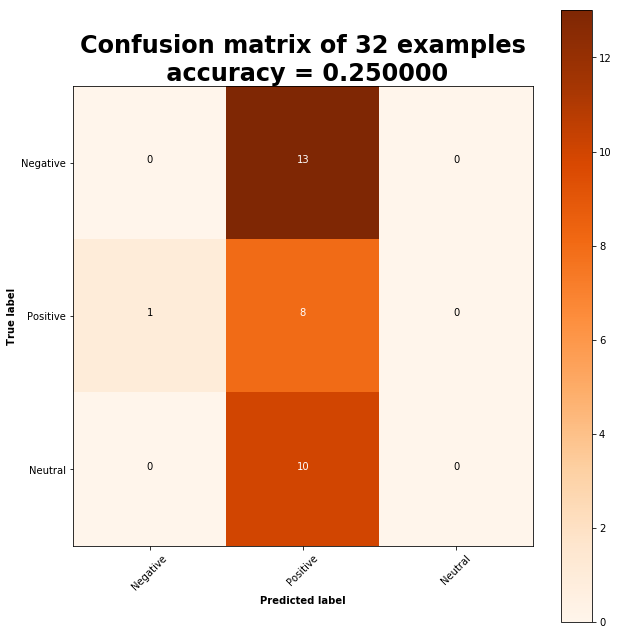

In [30]:
model = RNN(config)

valid_bach = next(iter(sent_data.valid_iter))
acc, pred, labels = model.evaluate_bach(valid_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

## Funções de treinamento

Aqui são as principais funções que são necessárias para se treinar o modelo

In [31]:
def train_epoch(model,
                iterator,
                optimizer,
                criterion):
    """
    Train a model over one epoch

    :param model: RNN classification model
    :type model: RNN 
    :param config: hyper param configuration
    :type config: RNNConfig
    :param iterator: data iterator
    :type iterator: torchtext.data.iterator.BucketIterator
    :param optimizer: torch optimazer
    :type optimizer: optim.SGD, optim.Adam, ...
    :param criterion: torch criterion (in this case CE)
    :type criterion: nn.CrossEntropyLoss
    """
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    """
    Get loss from valid data

    :param model: RNN classification model
    :type model: RNN 
    :param valid_iter: valid data iterator
    :type iterator: torchtext.data.iterator.BucketIterator
    :type criterion: nn.CrossEntropyLoss
    :return: loss
    :rtype: torch.Tensor(shape=[])
    """
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model,
                                      config,
                                      dataholder,
                                      model_path,
                                      verbose=True):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: RNN
    :param config: hyper param configuration
    :type config: RNNConfig
    :param dataholder: data
    :type dataholder: DataHolder
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    for epoch in range(config.epochs):
        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train_epoch(model, train_iter, optimizer, criterion)
        valid_loss = get_valid_loss(model,valid_iter, criterion)
        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)
        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))    

## Realizando o treinamento

Vamos realizar um treinamento simples. Sempre lembrando que é a classe `RNNConfig` que controla os hiper parâmetros de treinamento.
depois de treinado os parâmetros do modelo vão ser salvos no arquivo `rnn.pkl`

In [32]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   epochs=8,
                   learning_rate=0.03,
                   embedding_dim=300,
                   rnn_dim=356,
                   momentum=0.8)

print("====Treinando com os hiper parâmetros====\n")
print(config)

model = RNN(config)

training_loop_text_classification(model,
                                  config,
                                  sent_data,
                                  "rnn.pkl")

====Treinando com os hiper parâmetros====

vocab_size = 1598
batch_size = 32
embedding_dim = 300
rnn_dim = 356
output_dim = 3
epochs = 8
learning_rate = 0.03
momentum = 0.8

epoch = (1/8)

train_loss = 0.897 | valid_loss = 0.365
train_acc = 0.6067500001192093

epoch = (2/8)

train_loss = 1.277 | valid_loss = 1.315
train_acc = 0.5443125000596046

epoch = (3/8)

train_loss = 1.498 | valid_loss = 0.365
train_acc = 0.5240208333730698

epoch = (4/8)

train_loss = 0.551 | valid_loss = 0.421
train_acc = 0.731708333492279

epoch = (5/8)

train_loss = 0.509 | valid_loss = 0.277
train_acc = 0.7471041667461396

epoch = (6/8)

train_loss = 0.436 | valid_loss = 0.209
train_acc = 0.7423958331346512

epoch = (7/8)

train_loss = 0.395 | valid_loss = 0.269
train_acc = 0.7551875001192093

epoch = (8/8)

train_loss = 0.457 | valid_loss = 0.359
train_acc = 0.745145833492279



Depois de treinado o modelo, vamos carregar os parâmetros salvos e ver como o modelo está predizendo os dados de validação

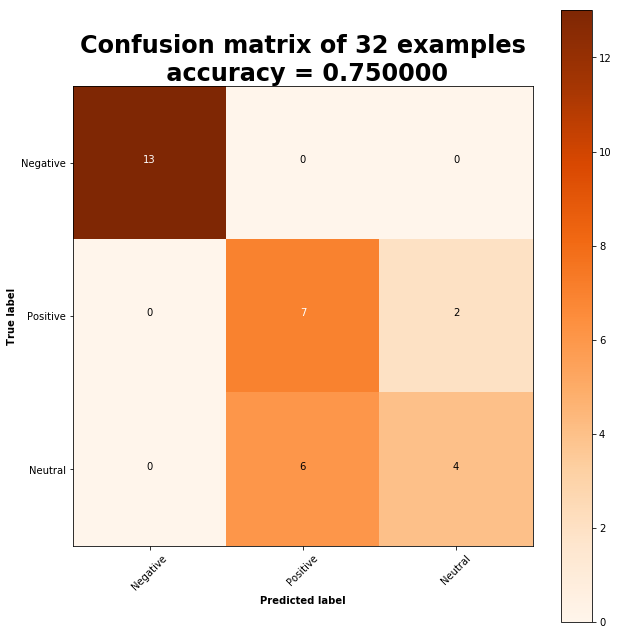

In [33]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))
_, pred, labels = model.evaluate_bach(valid_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Depois de treinado o modelo podemos ver como ele avalia certos exemplos

In [34]:
ex1 = "Rurique era sensível" # positivo
ex2 = "Nice sempre foi dissimulada" # negativo
ex3 = "Betina é tanto ponderada quanto indiferente" # neutro
ex4 = "Mel parece ser quezilento, mas eu não sei" # neutro
examples = [ex1, ex2, ex3, ex4]

In [35]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))

print("====Como o modelo prediz certos exemplos====\n")

for example in examples:
    print()
    print("exemplo:", example)
    text = simple_pre_process_text(example)
    text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
    text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
    text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
    text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
    pred = int(model.predict(text_as_tensor))
    print("modelo: ", int2sentiment[pred])

====Como o modelo prediz certos exemplos====


exemplo: Rurique era sensível
modelo:  Positive

exemplo: Nice sempre foi dissimulada
modelo:  Neutral

exemplo: Betina é tanto ponderada quanto indiferente
modelo:  Positive

exemplo: Mel parece ser quezilento, mas eu não sei
modelo:  Negative


## Próximos passos

O que foi descrito aqui são as etapas mais básicas, ainda tem muita coisa a ser feita. 

- Não está claro quais são os melhores hiperpâmetros. Vale a pena realizar vários treinamentos e selecionar quais são os modelos com melhor acurácia no dataset de validação. Depois de feito isso o resultado final do treinamento deve ser avaliado no dataset de teste. Use `test_bach = next(iter(sent_data.test_iter))` e gere a matriz de confusão.

- Aqui foi usado apenas um modelo composto por uma **RNN**, mas poderia ser usado uma **GRU** e **LSTM**. Tente construir modelos fazendo uso das classes`nn.GRU` e `nn.LSTM`.

- Depois de dominado esse exemplo é importante ir para o **mundo real!**. Ache um dataset interessante de análise de sentimentos (tweets sobre políticos, avaliação de produtos, resenhas de filmes, etc.) e tente aplicar essas técnicas.